# AdaBoost (Adaptive Boosting)

### The Core Idea: Focusing on the Hard Stuff
AdaBoost (1995) was the first successful boosting algorithm. Unlike Gradient Boosting (which uses residuals), AdaBoost uses **Sample Weights**.

1.  **Round 1:** Train a weak model (usually a **Stump** - a tree with only 1 split).
2.  **Weight Update:** Look at the samples the model got wrong. Increase their **Warning** (weight). Decrease the weight of the ones it got right.
3.  **Round 2:** Train a new stump. The model is forced to pay more attention to the "Heavy" (misclassified) samples.
4.  **Vote:** The final prediction is a weighted vote of all the stumps.

## Load Dataset (Breast Cancer)
We'll use a Binary Classification problem (Benign vs Malignant) as it's the classic use case for AdaBoost.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Load Data
data = load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Shape: {X.shape}")

Data Shape: (569, 30)


## The "Stump" vs. The Booster
A "Decision Stump" is a tree with `max_depth=1`. It's a very weak learner (basically just one rule, like "If Radius > 15, then Malignant").

We will see if a team of 50 stumps can beat a full Decision Tree.

In [2]:
# 1. A Single Decision Stump (Weak Learner)
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)
acc_stump = accuracy_score(y_test, stump.predict(X_test))

# 2. AdaBoost (50 Stumps)
# algorithm='SAMME' is the standard discrete boosting
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, algorithm='SAMME', random_state=42)
ada.fit(X_train, y_train)
acc_ada = accuracy_score(y_test, ada.predict(X_test))

print(f"Single Stump Accuracy: {acc_stump:.4f}")
print(f"AdaBoost Accuracy:     {acc_ada:.4f}")
print(f"Improvement:           +{(acc_ada - acc_stump)*100:.1f}%")

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Single Stump Accuracy: 0.8947
AdaBoost Accuracy:     0.9649
Improvement:           +7.0%


## Visualizing Sample Weights (Conceptual)
It's hard to visualize 30 dimensions, so let's use a synthetic dataset to see how AdaBoost "focuses" on hard points.

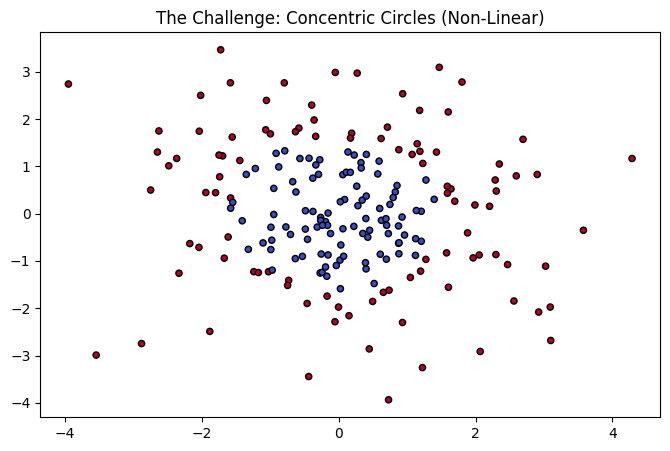

In [3]:
from sklearn.datasets import make_gaussian_quantiles

# Create synthetic data (Concentric circles - hard to separate with a straight line)
X1, y1 = make_gaussian_quantiles(cov=2.0, n_samples=200, n_features=2, n_classes=2, random_state=1)

plt.figure(figsize=(8, 5))
plt.scatter(X1[:, 0], X1[:, 1], c=y1, cmap='coolwarm', s=20, edgecolor='k')
plt.title("The Challenge: Concentric Circles (Non-Linear)")
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


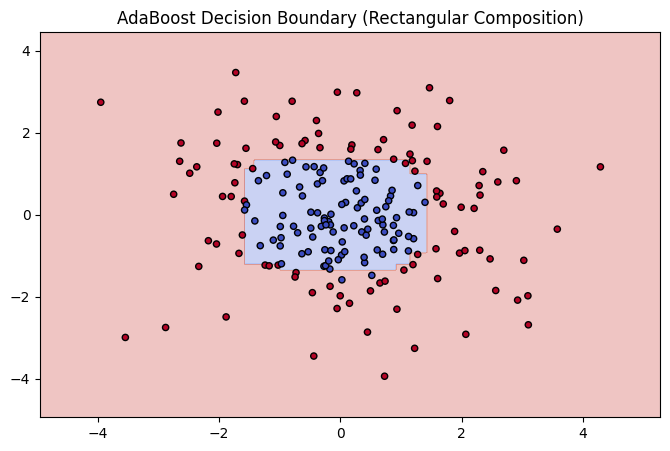

In [4]:
# Train AdaBoost on this 2D data
ada_2d = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, algorithm='SAMME', random_state=42)
ada_2d.fit(X1, y1)

# Plot Decision Boundary
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = ada_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 5))
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, cmap='coolwarm', s=20, edgecolor='k')
plt.title("AdaBoost Decision Boundary (Rectangular Composition)")
plt.show()

### Conclusion
Notice how the decision boundary is made of many "boxy" shapes? That's because it's combining many simple vertical/horizontal splits (Stumps) to approximate the circle.

### Final Model
$$
F(x) = \sum_{t=1}^T \alpha_t h_t(x)
$$

### Objective (Exponential Loss)
$$
\min_{F} \sum_{i=1}^N e^{-y_i F(x_i)}
$$


### Algorithm

1. **Initialize weights**
$$
w_i = \frac{1}{N}, \quad i = 1, \dots, N
$$

2. **For each boosting round \(t = 1, \dots, T\):**
- Train weak learner \(h_t(x) \in \{-1, +1\}\) using weights \(w_i\)
- Compute weighted error:
$$
\epsilon_t = \sum_{i=1}^N w_i \,\mathbb{1}[h_t(x_i) \neq y_i]
$$
- Compute learner weight:
$$
\alpha_t = \frac{1}{2}\log\frac{1-\epsilon_t}{\epsilon_t}
$$
- Update sample weights:
$$
w_i \leftarrow w_i \exp\big(-\alpha_t y_i h_t(x_i)\big)
$$
- Normalize weights so that:
$$
\sum_{i=1}^N w_i = 1
$$

3. **Output final model**
$$
F(x) = \sum_{t=1}^T \alpha_t h_t(x)
$$

---

### Notes
- Misclassified samples receive higher weights; correctly classified samples receive lower weights.
- The algorithm performs stage-wise additive modeling that minimizes exponential loss.
- Each weak learner must satisfy:
$$
\epsilon_t < \frac{1}{2}
$$
